# Quantitative and Categorical Data for EDA and Price Analysis


We are performing an inner join based on UUID, then drop null values.

 **There might be concerns here**: null values might be due to rules, and will exclude the majority of cards.
 - Power: only for creatures
 - toughness: only for creatures
 - Color Identity: not for instants and spells

 
If we remove all cards but Creature, can we make claims about the data in general terms? Decide to incorporate this into my analysis


In [64]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [65]:
# Card info
cards_csv = pd.read_csv('../dataset/cards.csv', sep=";")
prices_csv = pd.read_csv('../dataset/cardPrices.csv', sep=",")

all_data = pd.merge(prices_csv, cards_csv, on="uuid")

# Attributes that will always be null because their are based on game rules
rule_based_attributes = ['power', 'toughness']
subset = all_data.columns.difference(rule_based_attributes)


all_data.dropna(subset=subset, inplace=True)
#print(f"Number of NA values: \n{all_data.isnull().sum()} \n")

data = all_data.reset_index(drop=True)


mapped_data = data.select_dtypes(include=['number'])
label_encoder = LabelEncoder()

# one-hot categorical data for general analysis
to_encode = ['rarity', 'artist', 'finishes', 'currency','hasFoil' , 'supertypes',
             'hasNonFoil',  'gameAvailability', 'priceProvider', 'setCode', 'type']
for enc in to_encode:    
    mapped_data[enc] = label_encoder.fit_transform(data[enc])

mapped_data.columns

Index(['price', 'edhrecRank', 'edhrecSaltiness', 'manaValue', 'rarity',
       'artist', 'finishes', 'currency', 'hasFoil', 'supertypes', 'hasNonFoil',
       'gameAvailability', 'priceProvider', 'setCode', 'type'],
      dtype='object')

In [66]:
# Update mapped file
mapped_data.to_csv('../dataset/mapped_data.csv', index=False)
mapped_data.head()

,price,edhrecRank,edhrecSaltiness,manaValue,rarity,artist,finishes,currency,hasFoil,supertypes,hasNonFoil,gameAvailability,priceProvider,setCode,type
0,0.02,9476.0,0.84,8.0,3,84,3,1,1,0,1,0,0,104,55
1,0.03,9476.0,0.84,8.0,3,84,3,1,1,0,1,0,0,104,55
2,1.87,9476.0,0.84,8.0,3,84,3,1,1,0,1,1,4,104,55
3,29.16,9476.0,0.84,8.0,3,84,3,1,1,0,1,1,4,104,55
4,0.91,9476.0,0.84,8.0,3,84,3,0,1,0,1,1,2,104,55


In [67]:
# Remove outliers to anbalyze prices
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

mapped_data = removeOutliers(mapped_data, 'price')


In [68]:
import statsmodels.api as sm

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

model = sm.OLS(y, X)    # Describe model

result = model.fit()       # Fit model

print(result.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              712.7
Date:                Sun, 06 Oct 2024   Prob (F-statistic):                        0.00
Time:                        21:54:13   Log-Likelihood:                         -15717.
No. Observations:                8271   AIC:                                  3.146e+04
Df Residuals:                    8258   BIC:                                  3.155e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [69]:
fstat, pvalue = sm.stats.linear_rainbow(result)
print(f' f stat: {fstat} | p value: {pvalue}')

 f stat: 1.622412711197133 | p value: 2.7830817529949346e-54


# Interpretation of results (NEED REVISION)

#### R-squared and Adjusted R-squared
- **R-squared (0.525)**: This indicates that approximately **52.5%** of the variability in card prices can be explained by the independent variables included in the model. This suggests a moderate level of explanatory power.
  
- **Adjusted R-squared (0.524)**: This value adjusts for the number of predictors in the model, confirming that the model's explanatory power remains consistent even after accounting for additional variables.

#### F-statistic and Prob (F-statistic)
- **F-statistic (701.3)**: A high F-statistic indicates that at least one predictor variable significantly contributes to explaining the variability in price. We suspect the priceProvider and gameAvailability are the candidates here.
  
- **Prob (F-statistic) (0.00)**: This p-value indicates that the overall regression model is statistically significant, meaning that the independent variables collectively have a significant effect on card prices.

The OLS regression results suggest several factors significantly influence card prices, including EDHREC saltiness, mana value, rarity, and whether the card is foil or not:

- The negative impact of rarity on price may indicate market dynamics where rarer cards are less frequently sold or valued differently.
  
- The positive relationship between EDHREC saltiness and price suggests that cards perceived as more desirable or playable are valued higher by collectors and players.

---

# Linear Regression Prediction

In [70]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression model and use it based on selected feature and target
def prediction(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_test, y_pred, mse, r2

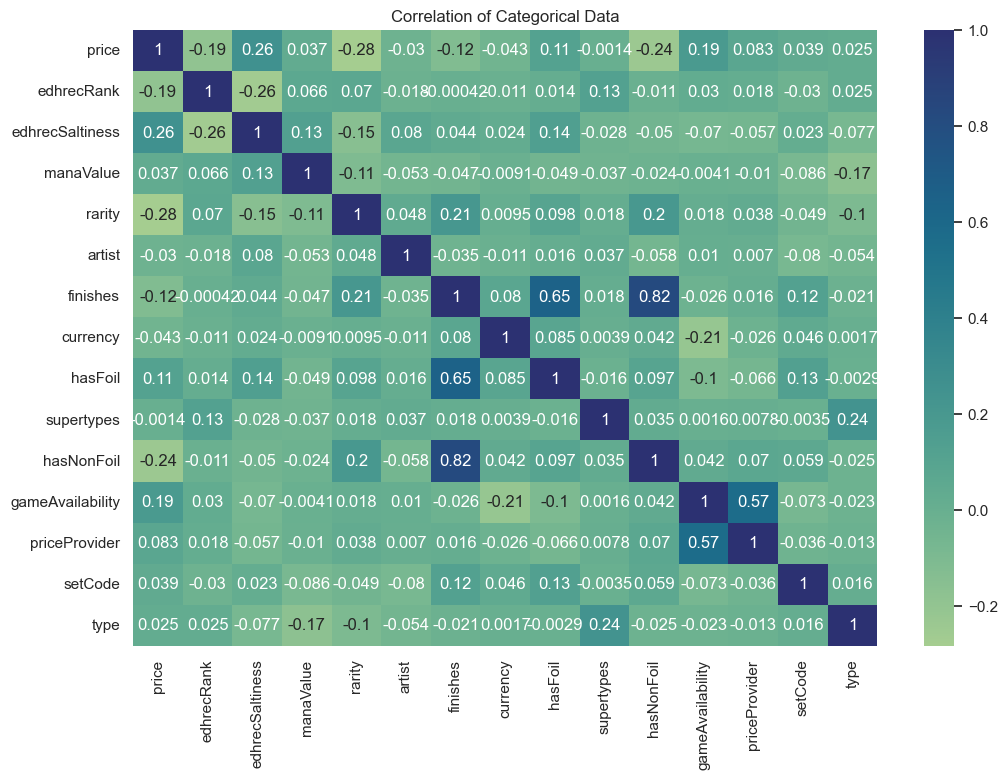

In [71]:

plt.figure(figsize=(12,8))
sns.heatmap(mapped_data.corr(),annot=True, cmap="crest")
plt.title("Correlation of Categorical Data")
plt.show()

Mean Squared Error: 2.3672367616454713
R-squared: 0.3179377963861356


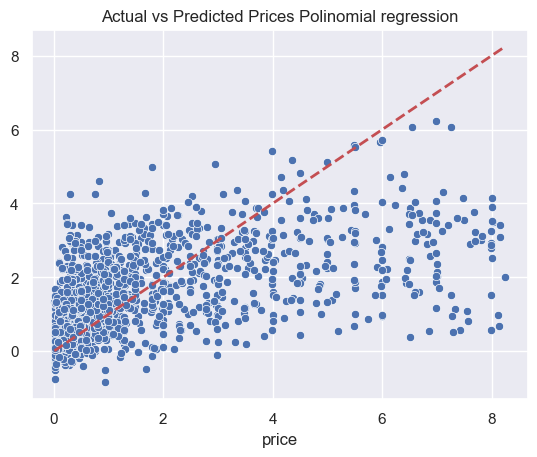

In [75]:
import statsmodels.api as sm
# Price Prediction based on Rank

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

# Polinomial Linear Regression
y_test, y_pred, mse, r2 = prediction(X, y)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Ploting results
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted Prices Polinomial regression')
plt.show()

---

# Random Forest implementation


In [79]:
# Random Forest implementation

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [80]:

# define features
X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
#convert y values to categorical values
y = mapped_data["price"]


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)


Mean Squared Error: 1.3988586257249884
R-squared: 0.5985930742350839
             feature  importance
0         edhrecRank    0.175640
1    edhrecSaltiness    0.140204
4             artist    0.097926
3             rarity    0.095393
11     priceProvider    0.090698
13              type    0.083532
12           setCode    0.082060
2          manaValue    0.056219
5           finishes    0.045517
7            hasFoil    0.041158
10  gameAvailability    0.039103
9         hasNonFoil    0.031855
6           currency    0.018244
8         supertypes    0.002453


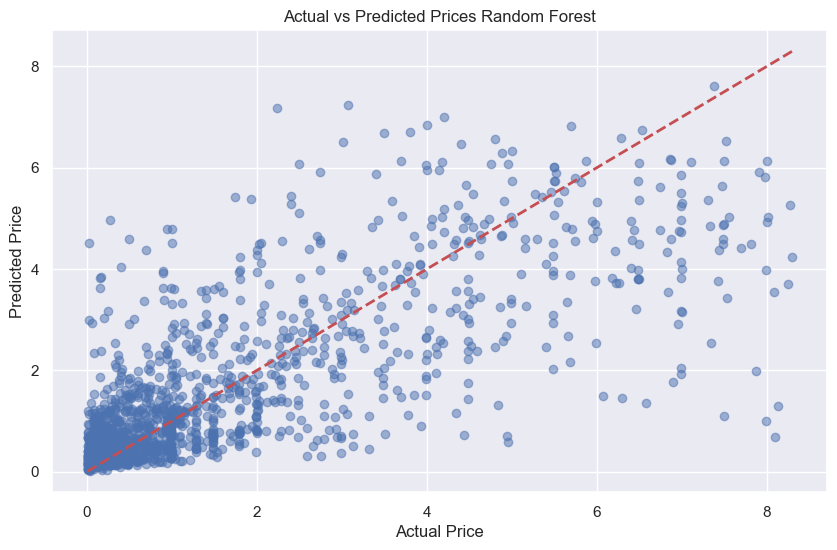

In [81]:

# Make predictions
y_pred = rf.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)


# Visualize actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices Random Forest')
plt.show()


# Interpretation

1. Model Performance:
   - Mean Squared Error (MSE): 1.3157145341214689
      
   - R-squared: 0.5729465850400793
     This R-squared value indicates that approximately 57.29% of the variance in card prices is explained by the model. 

2. Feature Importance:
   

   a. edhrecRank (17.65%): a card's popularity in EDH/Commander format significantly influences its price.
   
   b. edhrecSaltiness (14.32%): The second most important feature, indicating that community sentiment about a card's power level or fairness is a strong price predictor.
   
   c. rarity (10.16%): As expected, the rarity of a card plays a significant role in determining its price.
   
   d. artist (9.44%): The artist of the card has a notable impact on price, possibly due to certain artists being more popular or sought after.
   
   e. priceProvider (8.31%): This suggests that different price providers have varying impacts on the listed prices.


3. Insights:
   - The model now captures a more nuanced relationship between features and price, as evidenced by the improved R-squared value.
   - The importance of edhrecRank and edhrecSaltiness highlights the significant impact of community perception and card popularity on pricing.
   - The high importance of the artist feature suggests that certain artists' works command higher prices, which could be valuable information for collectors.
   - Game-related features (manaValue, gameAvailability) have moderate importance, indicating that a card's utility in gameplay does influence its price, but perhaps not as much as its collectible aspects.

4. Model Improvement:
   The significant improvement in both MSE and R-squared suggests that the corrections made to the Random Forest implementation 

5. Potential Applications:
   - This model could be used to estimate fair market prices for Magic: The Gathering cards, helping both buyers and sellers in the market.
   - It could assist in identifying undervalued or overvalued cards based on their features.
   - The feature importances could guide collectors and investors in understanding which card attributes are most likely to influence future value.

In conclusion, this Random Forest model provides a much more reliable and insightful analysis of Magic: The Gathering card prices compared to the previous attempt. It effectively captures the complex relationships between various card attributes and their market values, offering valuable insights for collectors, players, and market analysts in the trading card game industry.
